In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with tarfile.open("Datasets/higgs.tar.gz", "r:gz") as tar:
    # Cerca il file .csv corretto (ignora ._higgs.csv)
    for member in tar.getmembers():
        if member.name.endswith("higgs.csv") and not member.name.startswith("._"):
            f = tar.extractfile(member)
            if f is not None:
                df = pd.read_csv(f)
                print(df.head())

   EventId  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0   100000       138.470                       51.655        97.827    27.980   
1   100001       160.937                       68.768       103.235    48.146   
2   100002      -999.000                      162.172       125.953    35.635   
3   100003       143.905                       81.417        80.943     0.414   
4   100004       175.864                       16.915       134.805    16.405   

   DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0                  0.91           124.711                2.666   
1               -999.00          -999.000             -999.000   
2               -999.00          -999.000             -999.000   
3               -999.00          -999.000             -999.000   
4               -999.00          -999.000             -999.000   

   DER_deltar_tau_lep  DER_pt_tot  ...  PRI_jet_num  PRI_jet_leading_pt  \
0               3.064      41.928  ...   

In [ ]:
print(df.keys())

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')


In [3]:
df = df.mask(df == -999).dropna(how='any')

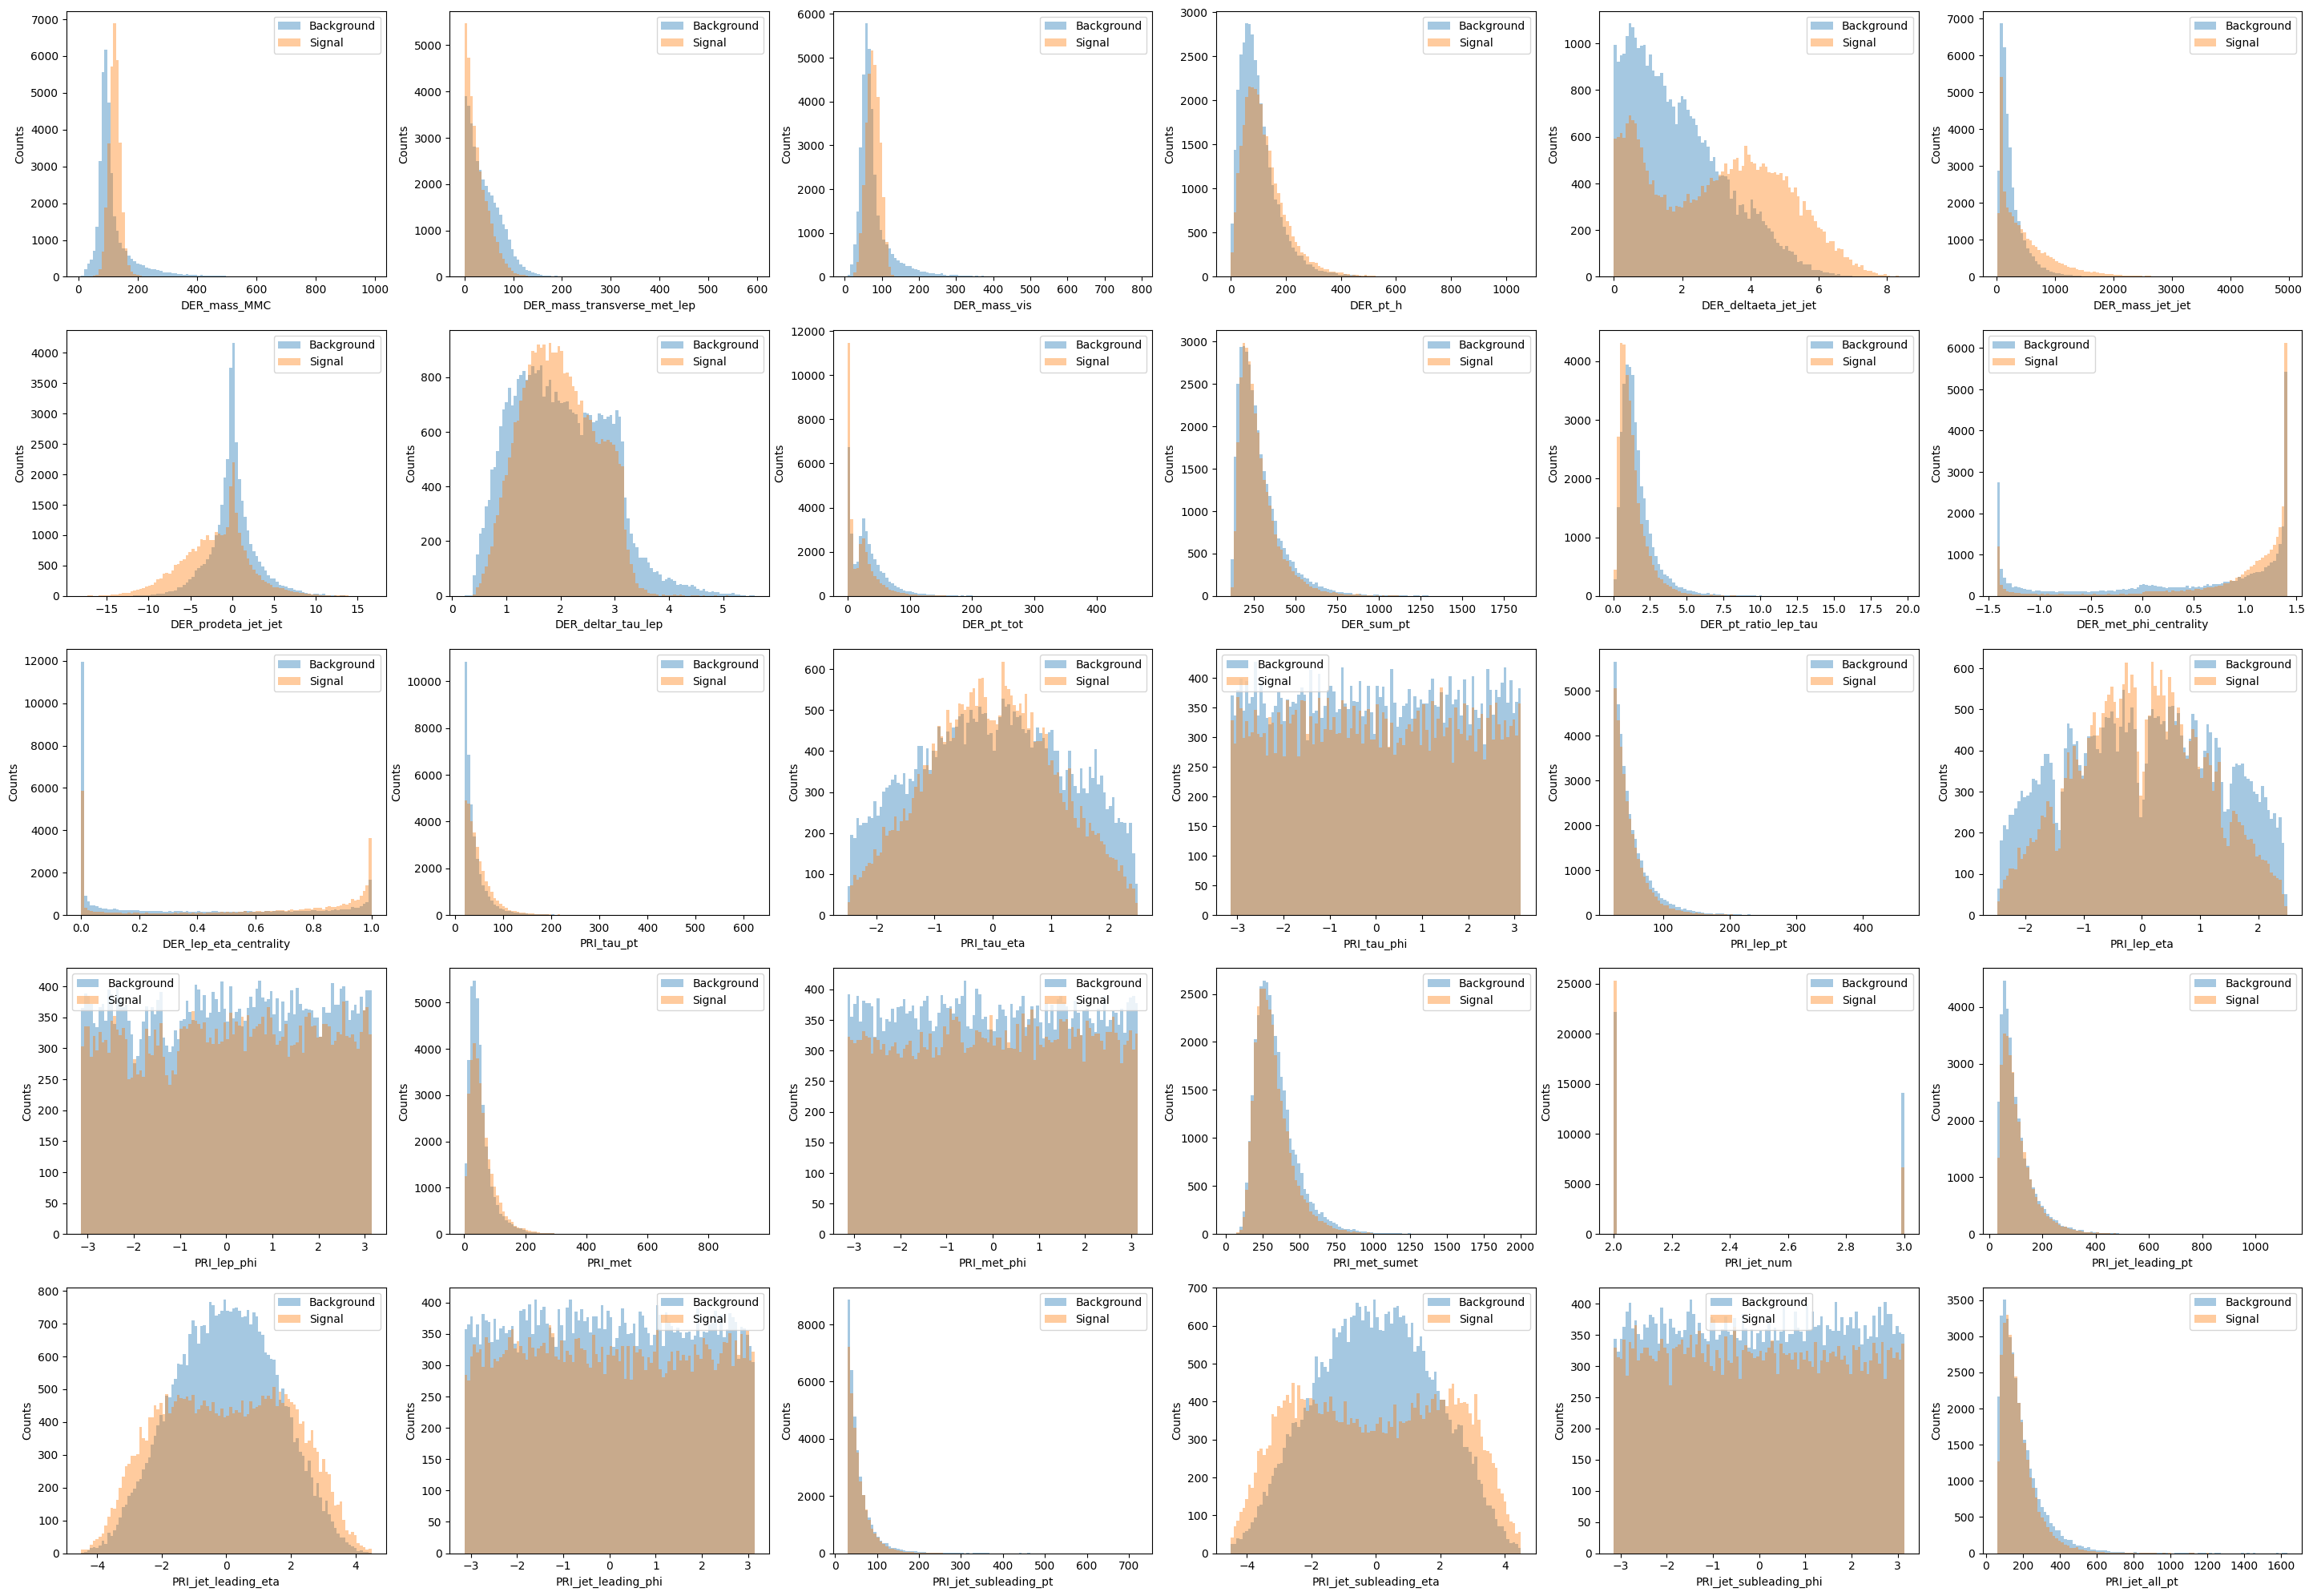

In [4]:
# saving only the keys that will later be used for the classification
remove = ['EventId','Weight', 'Label']
keys = [i for i in df.keys() if i not in remove]
tag = ['b','s']
name = ['Background','Signal']

fig,ax = plt.subplots(5,6,figsize=(36,25))
for i in range(5):
    for j in range(6):
        size=(min(df[keys[i*6+j]]), max(df[keys[i*6+j]]))
        for k in [0,1]:
            ax[i][j].hist(df[keys[i*6+j]][df['Label']==tag[k]],range=size,bins=100,alpha=0.4,label=name[k])
            ax[i][j].set(xlabel=keys[i*6+j],ylabel='Counts')
            ax[i][j].legend()
        

In [22]:
# dividing the dataset in a train and a validation set and rescaling the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = np.array([df[i][:] for i in keys]).T
y = np.array(df['Label'].map({'b': 0, 's': 1}).to_numpy())  #background == 0, signal == 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# MPLClassifier

In [23]:
# let's implement a first neural network using MLPClassifier
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='sgd', alpha=1e-3, 
                   hidden_layer_sizes=(10,10), 
                   learning_rate='adaptive',
                   random_state=42, max_iter=5000)
clf.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(10, 10),
              learning_rate='adaptive', max_iter=5000, random_state=42,
              solver='sgd')

Completeness:    0.8151
Contamination:   0.1616
Accuracy score:  0.8409


[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC curve')]

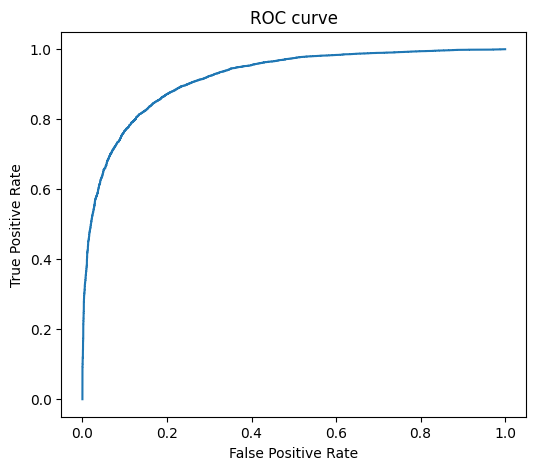

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, RocCurveDisplay

y_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

C = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print(f'Completeness:    {tp/(tp+fn):.4f}\nContamination:   {fp/(tp+fp):.4f}')
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score:  {acc:.4f}')
fpr, tpr, thresh = roc_curve(y_test, y_prob)
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(fpr,tpr)
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='ROC curve')

I tried using many setups with MPLClassifier but none seems effective in terms of the ROC curve.

So let's try something else

# Tensorflow

In [25]:
# let's now create a neural network using tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)
n_features = X_train.shape[1]
n_classes  = len(np.unique(y))

model = keras.Sequential()
model.add(layers.Input(shape=(n_features,)))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))


model.add(layers.Dense(1, activation="sigmoid"))
loss_fn = "binary_crossentropy"
metrics = ["accuracy"]


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=metrics
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=5, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,          # 20% del train come validation
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/200
1363/1363 - 12s - 9ms/step - accuracy: 0.7917 - loss: 0.4439 - val_accuracy: 0.8281 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 2/200
1363/1363 - 8s - 6ms/step - accuracy: 0.8282 - loss: 0.3882 - val_accuracy: 0.8341 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 3/200
1363/1363 - 9s - 6ms/step - accuracy: 0.8339 - loss: 0.3764 - val_accuracy: 0.8361 - val_loss: 0.3775 - learning_rate: 0.0010
Epoch 4/200
1363/1363 - 8s - 6ms/step - accuracy: 0.8386 - loss: 0.3718 - val_accuracy: 0.8384 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 5/200
1363/1363 - 8s - 6ms/step - accuracy: 0.8406 - loss: 0.3658 - val_accuracy: 0.8411 - val_loss: 0.3714 - learning_rate: 0.0010
Epoch 6/200
1363/1363 - 7s - 5ms/step - accuracy: 0.8401 - loss: 0.3628 - val_accuracy: 0.8403 - val_loss: 0.3682 - learning_rate: 0.0010
Epoch 7/200
1363/1363 - 7s - 5ms/step - accuracy: 0.8418 - loss: 0.3610 - val_accuracy: 0.8426 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 8/200
1363/1363 - 7s - 5ms/

426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy score: 0.8625


[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC curve')]

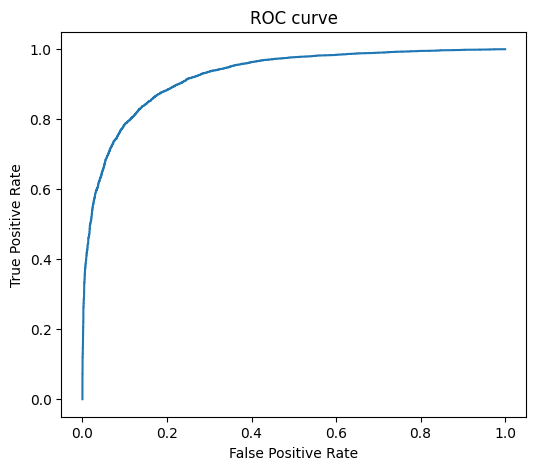

In [ ]:
y_pred_prob = model.predict(X_test).ravel()  # shape (n_samples,)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

tf_acc = model.evaluate(X_test,y_test)[1]

print(f'Accuracy score: {tf_acc:.4f}')

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(fpr,tpr)
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='ROC curve')

Now, let's test different architectures in order to find one that suits best our data.

In [28]:
loss_fn = "binary_crossentropy"
metrics = ["accuracy"]
acc = []
architecture = [[64], [128, 64], [256, 128, 64]]
for hidden_layers in architecture:
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    model.add(layers.Dense(hidden_layers[0], activation="relu"))
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss_fn,
        metrics=metrics
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, verbose=1
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,          # 20% of the train uis used as validation
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

    acc.append(model.evaluate(X_test,y_test)[1])

for i in range(len(architecture)):
    print(f'Architecture: {architecture[i]}, Accuracy: {acc[i]:.4f}')


Epoch 1/200
1363/1363 - 14s - 10ms/step - accuracy: 0.7908 - loss: 0.4414 - val_accuracy: 0.8232 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 2/200
1363/1363 - 7s - 5ms/step - accuracy: 0.8322 - loss: 0.3795 - val_accuracy: 0.8284 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 3/200
1363/1363 - 6s - 4ms/step - accuracy: 0.8368 - loss: 0.3723 - val_accuracy: 0.8313 - val_loss: 0.3941 - learning_rate: 0.0010
Epoch 4/200
1363/1363 - 6s - 4ms/step - accuracy: 0.8395 - loss: 0.3682 - val_accuracy: 0.8331 - val_loss: 0.3914 - learning_rate: 0.0010
Epoch 5/200
1363/1363 - 6s - 4ms/step - accuracy: 0.8405 - loss: 0.3652 - val_accuracy: 0.8327 - val_loss: 0.3895 - learning_rate: 0.0010
Epoch 6/200
1363/1363 - 6s - 4ms/step - accuracy: 0.8420 - loss: 0.3628 - val_accuracy: 0.8328 - val_loss: 0.3878 - learning_rate: 0.0010
Epoch 7/200
1363/1363 - 6s - 4ms/step - accuracy: 0.8430 - loss: 0.3608 - val_accuracy: 0.8336 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 8/200
1363/1363 - 6s - 4ms

Epoch 1/200
1363/1363 - 6s - 5ms/step - accuracy: 0.8164 - loss: 0.4049 - val_accuracy: 0.8318 - val_loss: 0.3863 - learning_rate: 0.0010
Epoch 2/200
1363/1363 - 5s - 4ms/step - accuracy: 0.8398 - loss: 0.3645 - val_accuracy: 0.8352 - val_loss: 0.3773 - learning_rate: 0.0010
Epoch 3/200
1363/1363 - 4s - 3ms/step - accuracy: 0.8441 - loss: 0.3554 - val_accuracy: 0.8363 - val_loss: 0.3740 - learning_rate: 0.0010
Epoch 4/200
1363/1363 - 4s - 3ms/step - accuracy: 0.8472 - loss: 0.3493 - val_accuracy: 0.8369 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 5/200
1363/1363 - 4s - 3ms/step - accuracy: 0.8498 - loss: 0.3440 - val_accuracy: 0.8371 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 6/200
1363/1363 - 4s - 3ms/step - accuracy: 0.8513 - loss: 0.3395 - val_accuracy: 0.8372 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 7/200
1363/1363 - 4s - 3ms/step - accuracy: 0.8536 - loss: 0.3353 - val_accuracy: 0.8385 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 8/200
1363/1363 - 5s - 4ms/s

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC curve')]

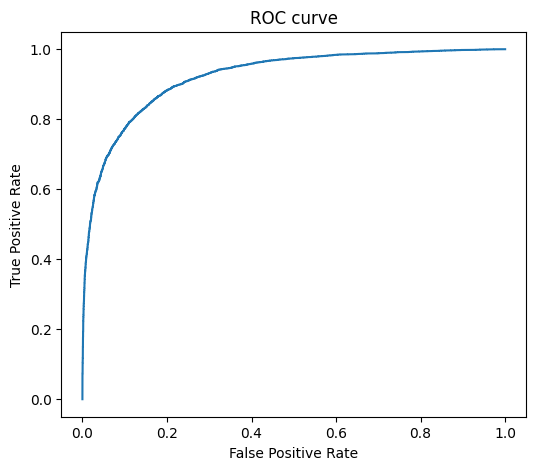

In [30]:
best_arc = architecture[np.argmax(acc)]
if(np.argmax(acc)!=len(acc)-1):
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    model.add(layers.Dense(best_arc[0], activation="relu"))
    for units in best_arc[1:]:
        model.add(layers.Dense(units, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
            
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss_fn,
        metrics=metrics
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, verbose=1
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,          # 20% of the train uis used as validation
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

y_pred_prob = model.predict(X_test).ravel()  # shape (n_samples,)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.plot(fpr,tpr)
ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate',title='ROC curve')

In [35]:
print(model.evaluate(X_test,y_test)[1])
print(model.predict(X_test))

426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8434 - loss: 0.3537
0.843646764755249
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[0.71158373]
 [0.38747838]
 [0.1328068 ]
 ...
 [0.04829406]
 [0.4302964 ]
 [0.9932857 ]]
